## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №11
Просрочит ли клиент микро-финансовой организации выплату более чем на 60 дней или нет?  
Построить модель, которая по входным данным предсказывала бы с максимальной точностью ключевой параметр.

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling

from math import nan
from datetime import datetime 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

DATA_CSV_PATH = 'MFOcredit.csv'

### Загрузка, анализ и преобразование данных

Предварительная загрузка и отображение части данных

In [2]:
df_sample = pd.read_csv(DATA_CSV_PATH, sep=';', nrows=3)
df_sample.head()

,id,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,1,03-Jan-2013,12-Jan-2013,Мужской,44,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Новосибирская область,Нет,Да,Нет
1,2,03-Jan-2013,17-Jan-2013,Мужской,21,Пропуск поля,Живут с родителями,Холост,Нет,Официальное,Кемеровская область юг,Да,Нет,Нет
2,3,03-Jan-2013,17-Jan-2013,Мужской,25,Пропуск поля,Собственное,Холост,Да,Официальное,Кемеровская область север,Пропуск поля,Нет,Нет


Загрузка требуемых данных: для признаков явно указываем требуемые типы, признак id исключаем из набора

In [3]:
dtypes={
    'date_start': object,
    'date_end': object,
    'gender': object,
    'age': int,
    'auto': object,
    'housing': object,
    'marstatus': object,
    'regclient': object,
    'jobtype': object,
    'region': object,
    'credits': object,
    'children': object,
    'delinq60plus': object
    }

# Получить список признаков набора данных
col_list = df_sample.columns.tolist()

# Исключить признак 'id' из выборки
cols = col_list[1:]

df_raw = pd.read_csv(DATA_CSV_PATH, usecols = cols, dtype = dtypes, sep=';')

# Привести все строковые значения к единому регистру, 
df_raw = df_raw.apply(lambda x: x.astype(str).str.lower() if x.dtype.name=='object' else x)

# Заменить значения "пропуск поля" на NULL/NAN
df_raw.replace('пропуск поля', nan, inplace=True)

df_raw.head()

,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,03-jan-2013,12-jan-2013,мужской,44,нет,собственное,гражданский брак/женат/замужем,нет,официальное,новосибирская область,нет,да,нет
1,03-jan-2013,17-jan-2013,мужской,21,NaN,живут с родителями,холост,нет,официальное,кемеровская область юг,да,нет,нет
2,03-jan-2013,17-jan-2013,мужской,25,NaN,собственное,холост,да,официальное,кемеровская область север,NaN,нет,нет
3,03-jan-2013,17-jan-2013,женский,47,NaN,собственное,гражданский брак/женат/замужем,да,официальное,кемеровская область север,нет,нет,нет
4,03-jan-2013,17-jan-2013,мужской,22,нет,арендуемое,гражданский брак/женат/замужем,нет,официальное,кемеровская область север,да,да,нет


Выделить и удалить строки-дубликаты

In [4]:
df_duplicateRows = df_raw[df_raw.duplicated()]
df_duplicateRows.shape

(107, 13)

In [5]:
df_raw = df_raw.drop_duplicates(keep='first')
df_raw.shape

(35105, 13)

Заменить признаки дат начала (date_start) и окончания (date_end) периода займа на интегральный признак срока займа (loan_term)

In [6]:
df_raw.insert(0,'loan_term', (pd.to_datetime(df_raw['date_end']) - pd.to_datetime(df_raw['date_start'])).dt.days)
df_raw.drop(['date_start','date_end'], inplace=True, axis=1)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35105 entries, 0 to 35211
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   loan_term     35105 non-null  int64 
 1   gender        35105 non-null  object
 2   age           35105 non-null  int32 
 3   auto          21107 non-null  object
 4   housing       27569 non-null  object
 5   marstatus     27608 non-null  object
 6   regclient     35105 non-null  object
 7   jobtype       20728 non-null  object
 8   region        35105 non-null  object
 9   credits       34160 non-null  object
 10  children      34361 non-null  object
 11  delinq60plus  35105 non-null  object
dtypes: int32(1), int64(1), object(10)
memory usage: 3.3+ MB


Перевести кетегориальные признаки с бинарными значениями в числовую форму (Да=1 , Нет=0)

In [7]:
df_raw['gender'] = df_raw['gender'].apply(lambda x: 1 if x == 'мужской' else 0 if x == 'женский' else nan)

df_raw['auto'] = df_raw['auto'].apply(lambda x: 1 if x == 'да' else 0 if x == 'нет' else nan)

df_raw['regclient'] = df_raw['regclient'].apply(lambda x: 1 if x == 'да' else 0 if x == 'нет' else nan)

df_raw['jobtype'] = df_raw['jobtype'].apply(lambda x: 1 if x == 'официальное' else 0 if x == 'неофициальное' else nan)

df_raw['credits'] = df_raw['credits'].apply(lambda x: 1 if x == 'да' else 0 if x == 'нет' else nan)

df_raw['children'] = df_raw['children'].apply(lambda x: 1 if x == 'да' else 0 if x == 'нет' else nan)

df_raw['delinq60plus'] = df_raw['delinq60plus'].apply(lambda x: 1 if x == 'да' else 0 if x == 'нет' else nan)

df_raw['delinq60plus'].value_counts()

0    21614
1    13491
Name: delinq60plus, dtype: int64

Выполнить анализ пропущенных значений

In [8]:
for col in df_raw.columns:
    pct_missing = df_raw[col].count()
    print(f'{col} ({df_raw[col].dtype}) - {df_raw[col].__len__() - pct_missing}')

loan_term (int64) - 0
gender (int64) - 0
age (int32) - 0
auto (float64) - 13998
housing (object) - 7536
marstatus (object) - 7497
regclient (int64) - 0
jobtype (float64) - 14377
region (object) - 0
credits (float64) - 945
children (float64) - 744
delinq60plus (int64) - 0


Выполнить анализ существующих категорий

In [9]:
df_raw.describe() #(include=[object])

,loan_term,gender,age,auto,regclient,jobtype,credits,children,delinq60plus
count,35105.000000,35105.000000,35105.000000,21107.000000,35105.000000,20728.000000,34160.000000,34361.000000,35105.000000
mean,14.541404,0.480758,37.247030,0.173781,0.559635,0.943699,0.470931,0.386834,0.384304
std,7.000318,0.499637,13.182539,0.378930,0.496438,0.230507,0.499162,0.487032,0.486437
min,1.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,0.000000,26.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,14.000000,0.000000,34.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,14.000000,1.000000,48.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,181.000000,1.000000,75.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Замена отсутствующих значений категориальных признаков на наиболее часто встречающееся значение из общей группы

In [10]:
# Для признака "children" - значение из группы по признакам 'gender','age','region'
df_raw['children'] = df_raw.groupby(['gender','age','region'])['children'].transform(lambda x: x.fillna(x.mode()[0] if x.count()>0 else nan))
df_raw['children'].value_counts()

0.0    21670
1.0    13435
Name: children, dtype: int64

In [11]:
df_raw['credits'] = df_raw.groupby(['gender','age','region'])['credits'].transform(lambda x: x.fillna(x.mode()[0] if x.count()>0 else nan))
df_raw['credits'].value_counts()

0.0    18659
1.0    16445
Name: credits, dtype: int64

In [12]:
df_raw['marstatus'] = df_raw.groupby(['gender','age','region','children'])['marstatus'].transform(lambda x: x.fillna(x.mode()[0] if x.count()>0 else nan))
df_raw['marstatus'].value_counts()

гражданский брак/женат/замужем    18737
холост                            11142
разведен                           2879
вдова/вдовец                       2336
Name: marstatus, dtype: int64

In [13]:
df_raw['housing'] = df_raw.groupby(['gender','age','region'])['housing'].transform(lambda x: x.fillna(x.mode()[0] if x.count()>0 else nan))
df_raw['housing'].value_counts()

собственное              25207
живут с родителями        3520
долевая собственность     2984
арендуемое                2031
муниципальное             1359
Name: housing, dtype: int64

In [14]:
df_raw['auto'] = df_raw.groupby(['gender','age','region'])['auto'].transform(lambda x: x.fillna(x.mode()[0] if x.count()>0 else nan))
df_raw['auto'].value_counts()

0.0    31399
1.0     3698
Name: auto, dtype: int64

In [15]:
df_raw['jobtype'] = df_raw.groupby(['gender','age','region'])['jobtype'].transform(lambda x: x.fillna(x.mode()[0] if x.count()>0 else nan))
df_raw['jobtype'].value_counts()

1.0    33755
0.0     1255
Name: jobtype, dtype: int64

Удалить оставшиеся "пропущенные" (NAN) значения

In [16]:
df_raw.dropna(inplace=True)
df_raw.shape

(35003, 12)

~~Pазвернутый анализ данных c помощью библиотеки [Pandas Profiling](https://github.com/pandas-profiling/pandas-profiling)~~

In [17]:
#%%time
#pandas_profiling.ProfileReport(df_raw)

Разбиение признаков на группы числовых и категориальных признаков

In [17]:
num_columns = ['loan_term','age']
cat_columns = ['gender', 'auto', 'housing', 'marstatus', 'regclient', 'jobtype', 'region', 'credits', 'children', 'delinq60plus']

Проверка числовых признаков на наличие нетипичных значений (выбросов)

<AxesSubplot:>

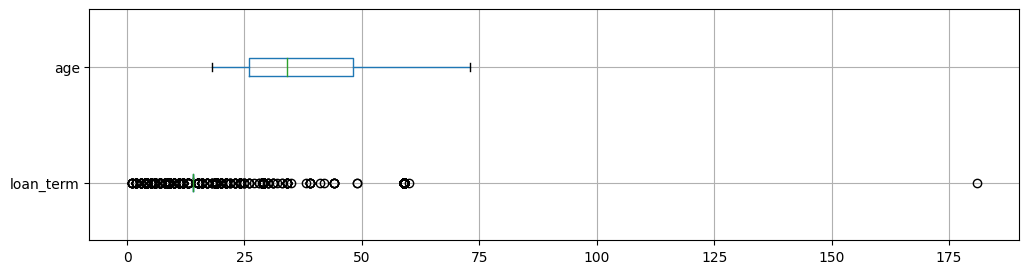

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3))

df_raw.boxplot(column=['loan_term','age'], vert=0 ) #, notch=True, patch_artist=True)

In [18]:
# Удалить значение выброса
df_raw = df_raw[df_raw.loan_term < 181]

df_raw.describe()

,loan_term,gender,age,auto,regclient,jobtype,credits,children,delinq60plus
count,35002.000000,35002.000000,35002.000000,35002.000000,35002.000000,35002.000000,35002.000000,35002.000000,35002.000000
mean,14.539941,0.480344,37.164076,0.105565,0.559311,0.964173,0.468745,0.383607,0.385121
std,6.950026,0.499621,13.100466,0.307285,0.496477,0.185860,0.499029,0.486271,0.486631
min,1.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,0.000000,26.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,14.000000,0.000000,34.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,14.000000,1.000000,48.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,60.000000,1.000000,73.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Выполнить скалирование числовых признаков

In [19]:
df_num = df_raw[num_columns]

for col in df_num.columns:
    df_num[col] = (df_num[col] - df_num[col].min()) / (df_num[col].max() - df_num[col].min())

df_num.describe()

C:\Windows\Temp\ipykernel_1136\3227844141.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[col] = (df_num[col] - df_num[col].min()) / (df_num[col].max() - df_num[col].min())


,loan_term,age
count,35002.000000,35002.000000
mean,0.229491,0.348438
std,0.117797,0.238190
min,0.000000,0.000000
25%,0.220339,0.145455
50%,0.220339,0.290909
75%,0.220339,0.545455
max,1.000000,1.000000


In [20]:
df_dummed = pd.get_dummies(df_raw[cat_columns])

data = pd.concat((df_num, df_dummed), axis=1)
data.head()

,loan_term,age,gender,auto,regclient,jobtype,credits,children,delinq60plus,housing_арендуемое,...,housing_собственное,marstatus_вдова/вдовец,marstatus_гражданский брак/женат/замужем,marstatus_разведен,marstatus_холост,region_алтайский край,region_кемеровская область север,region_кемеровская область юг,region_красноярский край,region_новосибирская область
0,0.135593,0.472727,1,0.0,0,1.0,0.0,1.0,0,0,...,1,0,1,0,0,0,0,0,0,1
1,0.220339,0.054545,1,0.0,0,1.0,1.0,0.0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0.220339,0.127273,1,0.0,1,1.0,1.0,0.0,0,0,...,1,0,0,0,1,0,1,0,0,0
3,0.220339,0.527273,0,0.0,1,1.0,0.0,0.0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,0.220339,0.072727,1,0.0,0,1.0,1.0,1.0,0,1,...,0,0,1,0,0,0,1,0,0,0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35002 entries, 0 to 35211
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   loan_term                                 35002 non-null  float64
 1   age                                       35002 non-null  float64
 2   gender                                    35002 non-null  int64  
 3   auto                                      35002 non-null  float64
 4   regclient                                 35002 non-null  int64  
 5   jobtype                                   35002 non-null  float64
 6   credits                                   35002 non-null  float64
 7   children                                  35002 non-null  float64
 8   delinq60plus                              35002 non-null  int64  
 9   housing_арендуемое                        35002 non-null  uint8  
 10  housing_долевая собственность     

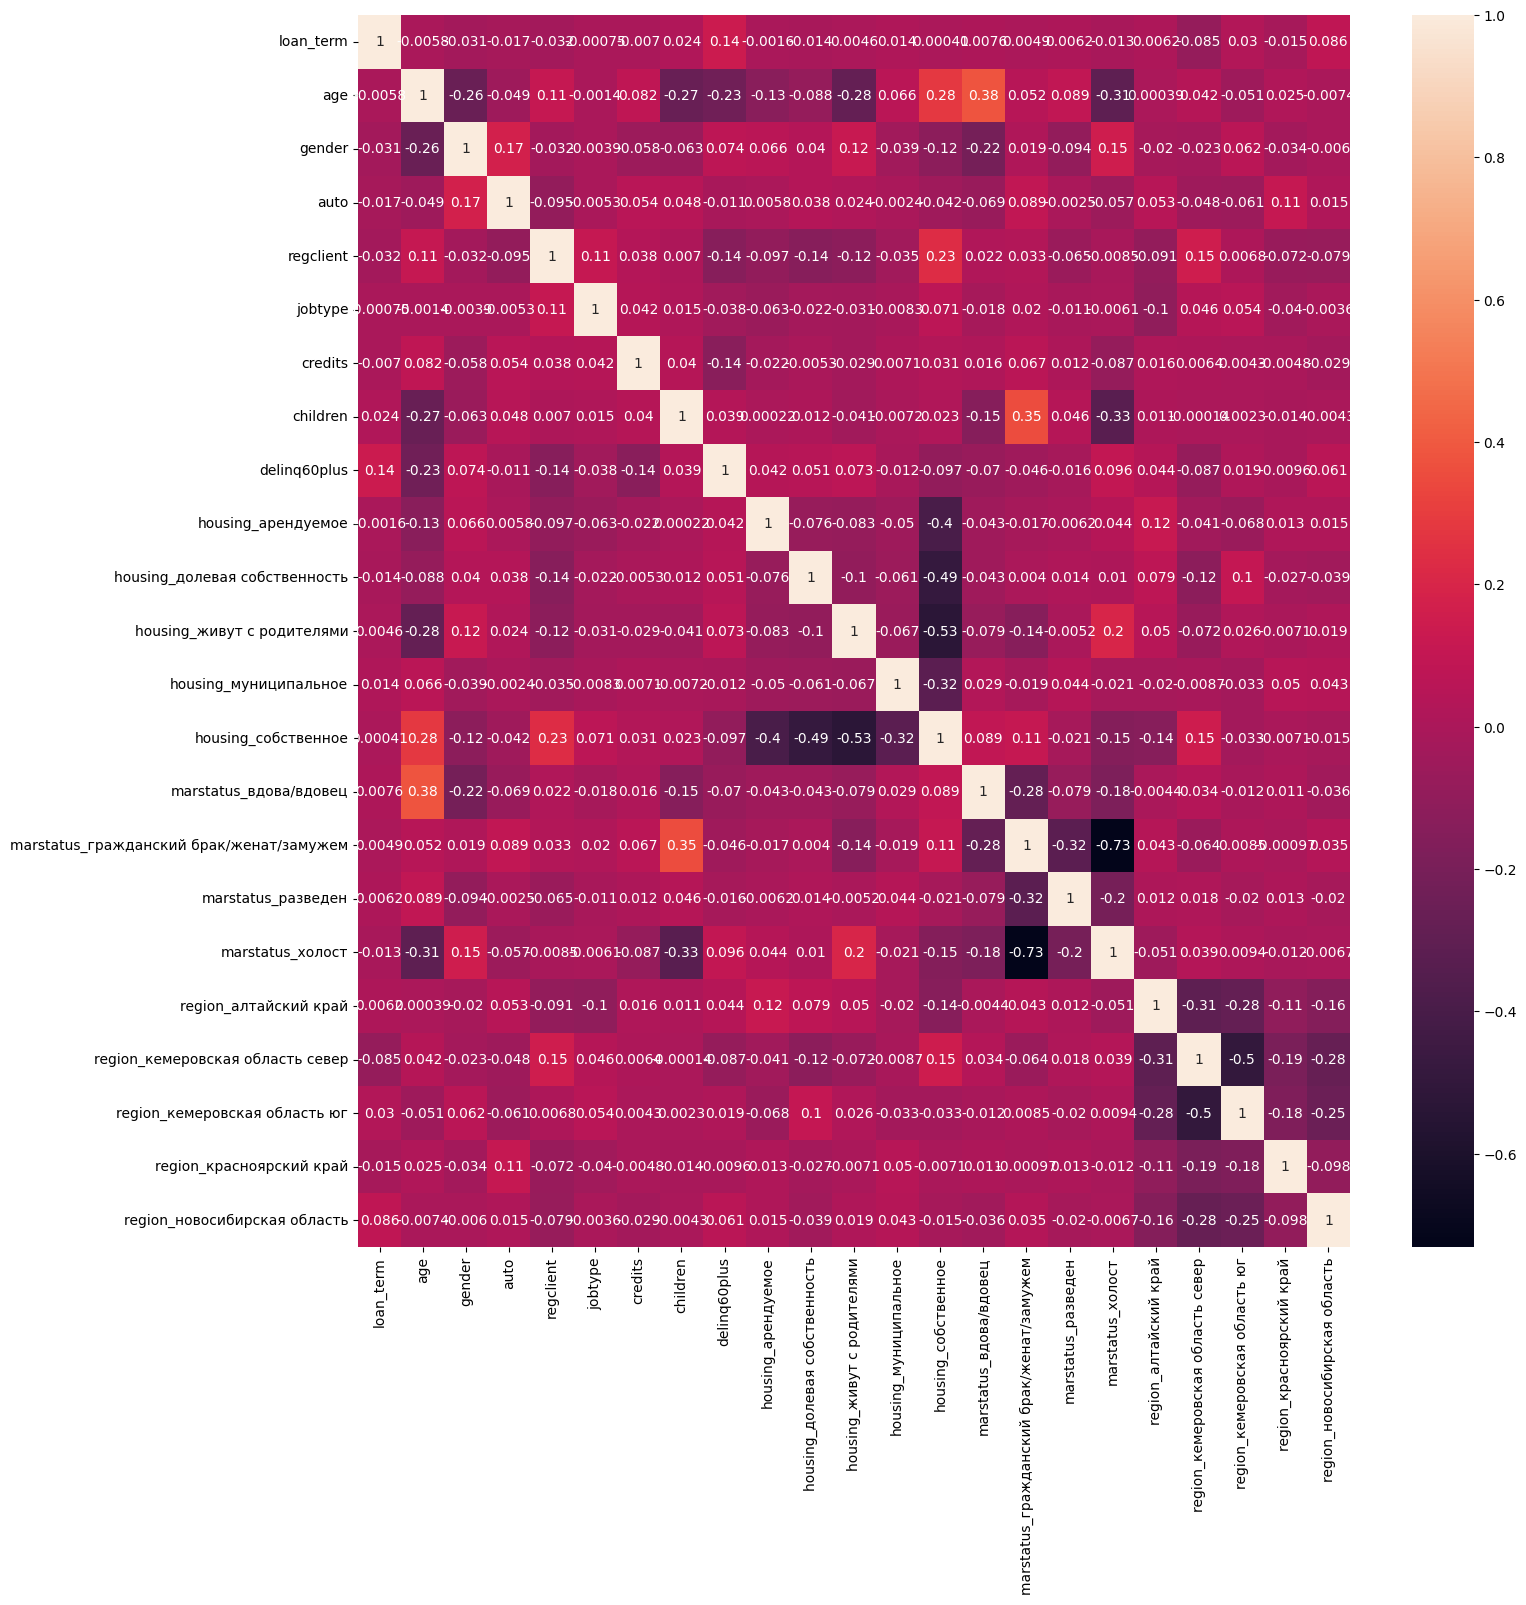

In [23]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(16,16))
sn.heatmap(data.corr(), annot=True, linewidths=0)
plt.show()

Выполнить разбиение исходной выборки данных на 2 подмножества (обучение и тестирование)

In [24]:
y = data['delinq60plus']
X = data.drop(['delinq60plus'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

Выполнить обучение и проверку модели

In [25]:
# Модель RandomForest
forest = (RandomForestClassifier)(n_estimators=200, max_depth=10, n_jobs=-1)
                                
forest.fit(X_train, y_train);

print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])))

AUC на обучающей выборке: 0.744
AUC на контрольной выборке: 0.691
